In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier, RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM


### Column Descriptions:

+ age (Age of the patient in years)
+ origin (place of study) - dataset
+ sex (Male/Female)
+ cp chest pain type ([typical angina, atypical angina, non-anginal, asymptomatic])
+ trestbps resting blood pressure (resting blood pressure (in mm Hg on admission to the hospital))
+ chol (serum cholesterol in mg/dl)
+ fbs (if fasting blood sugar > 120 mg/dl)
+ restecg (resting electrocardiographic results) -- Values: [normal, stt abnormality, lv hypertrophy]
+ thalach: maximum heart rate achieved
+ exang: exercise-induced angina (True/ False)
+ oldpeak: ST depression induced by exercise relative to rest
+ slope: the slope of the peak exercise ST segment
+ ca: number of major vessels (0-3) colored by fluoroscopy
+ thal: [normal; fixed defect; reversible defect]
+ num: the predicted attribute

In [3]:
# Ignore specific warnings to keep the output clean

warnings.filterwarnings("ignore", category=RuntimeWarning, module="pandas.core.arrays.base")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Load the dataset
df = pd.read_csv("heart_disease_uci.csv")

In [5]:
# check length
print("Dataset length:", len(df))

Dataset length: 920


In [6]:
# check df
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


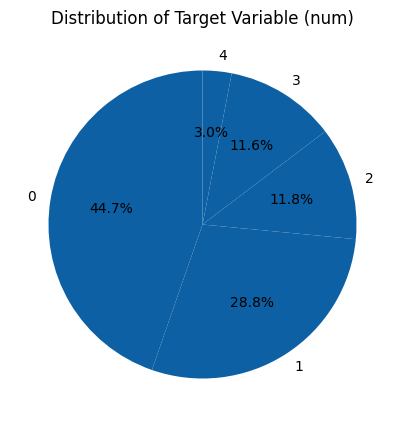

In [7]:
# Plot the distribution of the target variable 'num'

plt.figure(figsize=(8, 5))
df['num'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#0d60a3'])
plt.title('Distribution of Target Variable (num)')
plt.ylabel('')
plt.show()

In [8]:
# Display class distribution

class_distribution = df['num'].value_counts()
print("Class distribution:\n", class_distribution)

Class distribution:
 num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64


In [9]:
# Function to augment data for a specific class label

def augment_data(df, class_label, n_augmentations=3):
    df_class = df[df['num'] == class_label]
    augmented_data = []
    
    for _ in range(n_augmentations):
        df_aug = df_class.copy()
        
        # Add random noise to specific columns
        df_aug['age'] = df_aug['age'] + np.random.randint(-3, 4, df_aug.shape[0])
        df_aug['trestbps'] = df_aug['trestbps'] + np.random.randint(-3, 4, df_aug.shape[0])
        df_aug['chol'] = df_aug['chol'] + np.random.randint(-3, 4, df_aug.shape[0])
        df_aug['thalch'] = df_aug['thalch'] + np.random.randint(-3, 4, df_aug.shape[0])
        
        augmented_data.append(df_aug)
    
    return pd.concat(augmented_data)

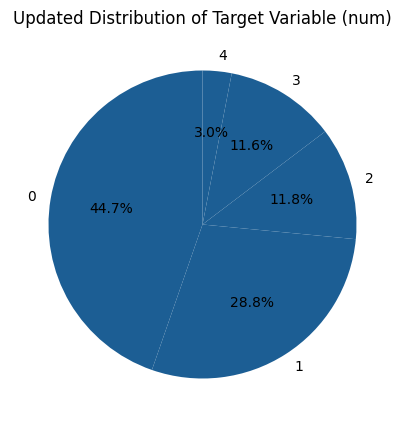

In [12]:
# Plot the updated distribution of the target variable

plt.figure(figsize=(8, 5))
df['num'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#1c5e94'])
plt.title('Updated Distribution of Target Variable (num)')
plt.ylabel('')
plt.show()

In [13]:
# check length
print("Dataset length:", len(df))

Dataset length: 920


In [14]:
# check unique values
df['dataset'].unique()

array(['Cleveland', 'Hungary', 'Switzerland', 'VA Long Beach'],
      dtype=object)

In [15]:
# check nans
df.isnull().sum()

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

In [16]:

# Data cleaning and preprocessing
df.drop(['id'], axis=1, inplace=True)

In [17]:
# Replace categorical labels with numerical ones

df['dataset'] = df['dataset'].map({
    'Cleveland': 1,
    'Hungary': 2,
    'Switzerland': 3,
    'VA Long Beach': 4
})

df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})

df['cp'] = df['cp'].map({
    'typical angina': 1,
    'atypical angina': 2,
    'non-anginal': 3,
    'asymptomatic': 4
})

df['restecg'] = df['restecg'].map({
    'normal': 0,
    'stt abnormality': 1,
    'lv hypertrophy': 2
})

df['fbs'] = df['fbs'].map({1: 1, 0: 0})
df['exang'] = df['exang'].map({1: 1, 0: 0})
df['slope'] = df['slope'].map({'downsloping': 1, 'flat': 2, 'upsloping': 3})
df['thal'] = df['thal'].map({'normal': 1, 'fixed defect': 2, 'reversible defect': 3})

In [18]:
# Fill missing values based on group means/modes

df['trestbps'] = df.groupby('num')['trestbps'].transform(lambda x: x.fillna(x.mean()))
df['chol'] = df.groupby('num')['chol'].transform(lambda x: x.fillna(x.mean()))
df['thalch'] = df.groupby('num')['thalch'].transform(lambda x: x.fillna(x.mean()))
df['oldpeak'] = df.groupby('num')['oldpeak'].transform(lambda x: x.fillna(x.mean()))
df['fbs'] = df.groupby('num')['fbs'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 0))
df['restecg'] = df.groupby('num')['restecg'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 0))
df['exang'] = df.groupby('num')['exang'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 0))
df['slope'] = df.groupby('num')['slope'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 0))
df['thal'] = df.groupby('num')['thal'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 0))
df['ca'] = df.groupby('num')['ca'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 0))

In [19]:
# Convert columns to integers after filling missing values

df['fbs'] = df['fbs'].astype(int)
df['restecg'] = df['restecg'].astype(int)
df['exang'] = df['exang'].astype(int)
df['slope'] = df['slope'].astype(int)
df['ca'] = df['ca'].astype(int)
df['thal'] = df['thal'].astype(int)

In [20]:
# check nans
df.isnull().sum()

age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

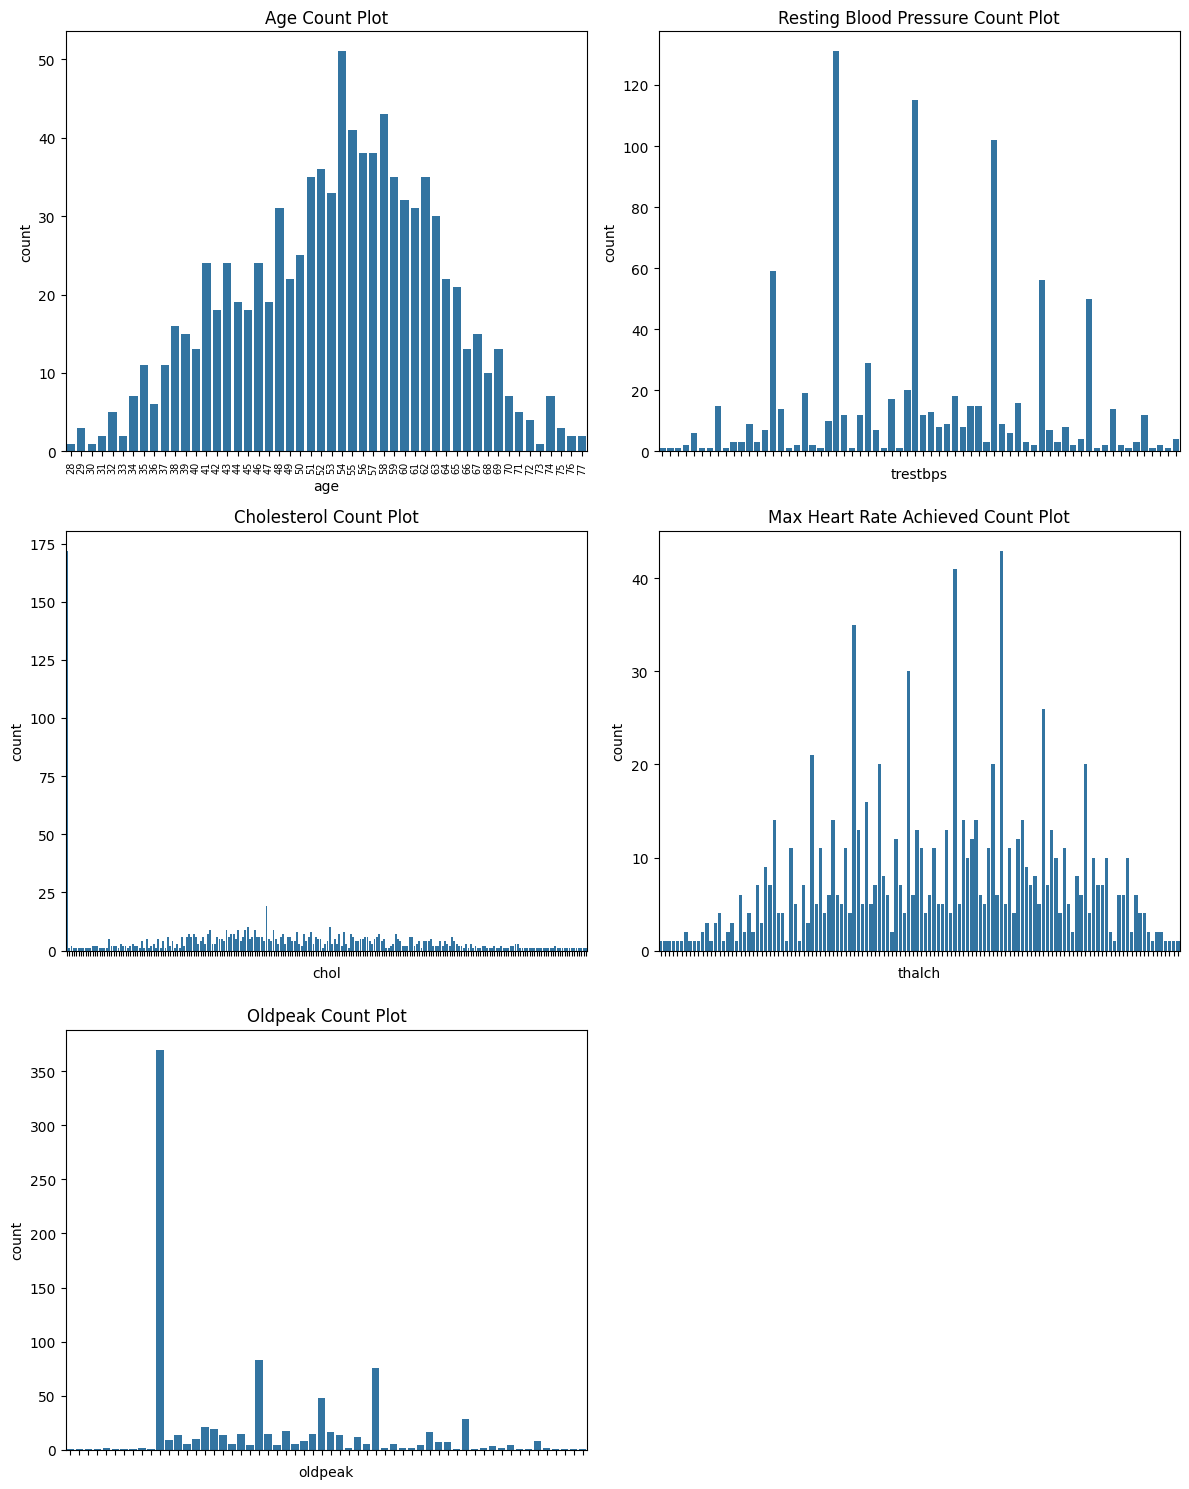

In [21]:
# Visualize feature distributions

fig, axs = plt.subplots(3, 2, figsize=(12, 15))

sns.countplot(x='age', data=df, ax=axs[0, 0])
axs[0, 0].set_title('Age Count Plot')
axs[0, 0].tick_params(axis='x', rotation=90, labelsize=7)

sns.countplot(x='trestbps', data=df, ax=axs[0, 1])
axs[0, 1].set_title('Resting Blood Pressure Count Plot')
axs[0, 1].set_xticklabels([])

sns.countplot(x='chol', data=df, ax=axs[1, 0])
axs[1, 0].set_title('Cholesterol Count Plot')
axs[1, 0].set_xticklabels([])

sns.countplot(x='thalch', data=df, ax=axs[1, 1])
axs[1, 1].set_title('Max Heart Rate Achieved Count Plot')
axs[1, 1].set_xticklabels([])

sns.countplot(x='oldpeak', data=df, ax=axs[2, 0])
axs[2, 0].set_title('Oldpeak Count Plot')
axs[2, 0].set_xticklabels([])

fig.delaxes(axs[2, 1])

plt.tight_layout()
plt.show()

In [22]:
df['chol'].dropna().sort_values()

627      0.0
788      0.0
718      0.0
787      0.0
676      0.0
       ...  
584    491.0
568    518.0
528    529.0
152    564.0
546    603.0
Name: chol, Length: 920, dtype: float64

In [23]:
# Create bins for continuous variables for easier interpretation

df['age'] = pd.cut(df['age'], bins=[0, 30, 40, 50, 60, 100], labels=[1, 2, 3, 4, 5])
df['trestbps'] = pd.cut(df['trestbps'], bins=[-4, 120, 130, 140, 150, 204], labels=[1, 2, 3, 4, 5])
df['chol'] = pd.cut(df['chol'], bins=[-4, 200, 240, 300, 350, 400, 500, 600, 607], labels=[1, 2, 3, 4, 5, 6, 7, 8])
df['thalch'] = pd.cut(df['thalch'], bins=[50, 100, 140, 160, 180, 220], labels=[1, 2, 3, 4, 5])
df['oldpeak'] = pd.cut(df['oldpeak'], bins=[-3, -2, 0, 2, 4, 7], labels=[1, 2, 3, 4, 5])

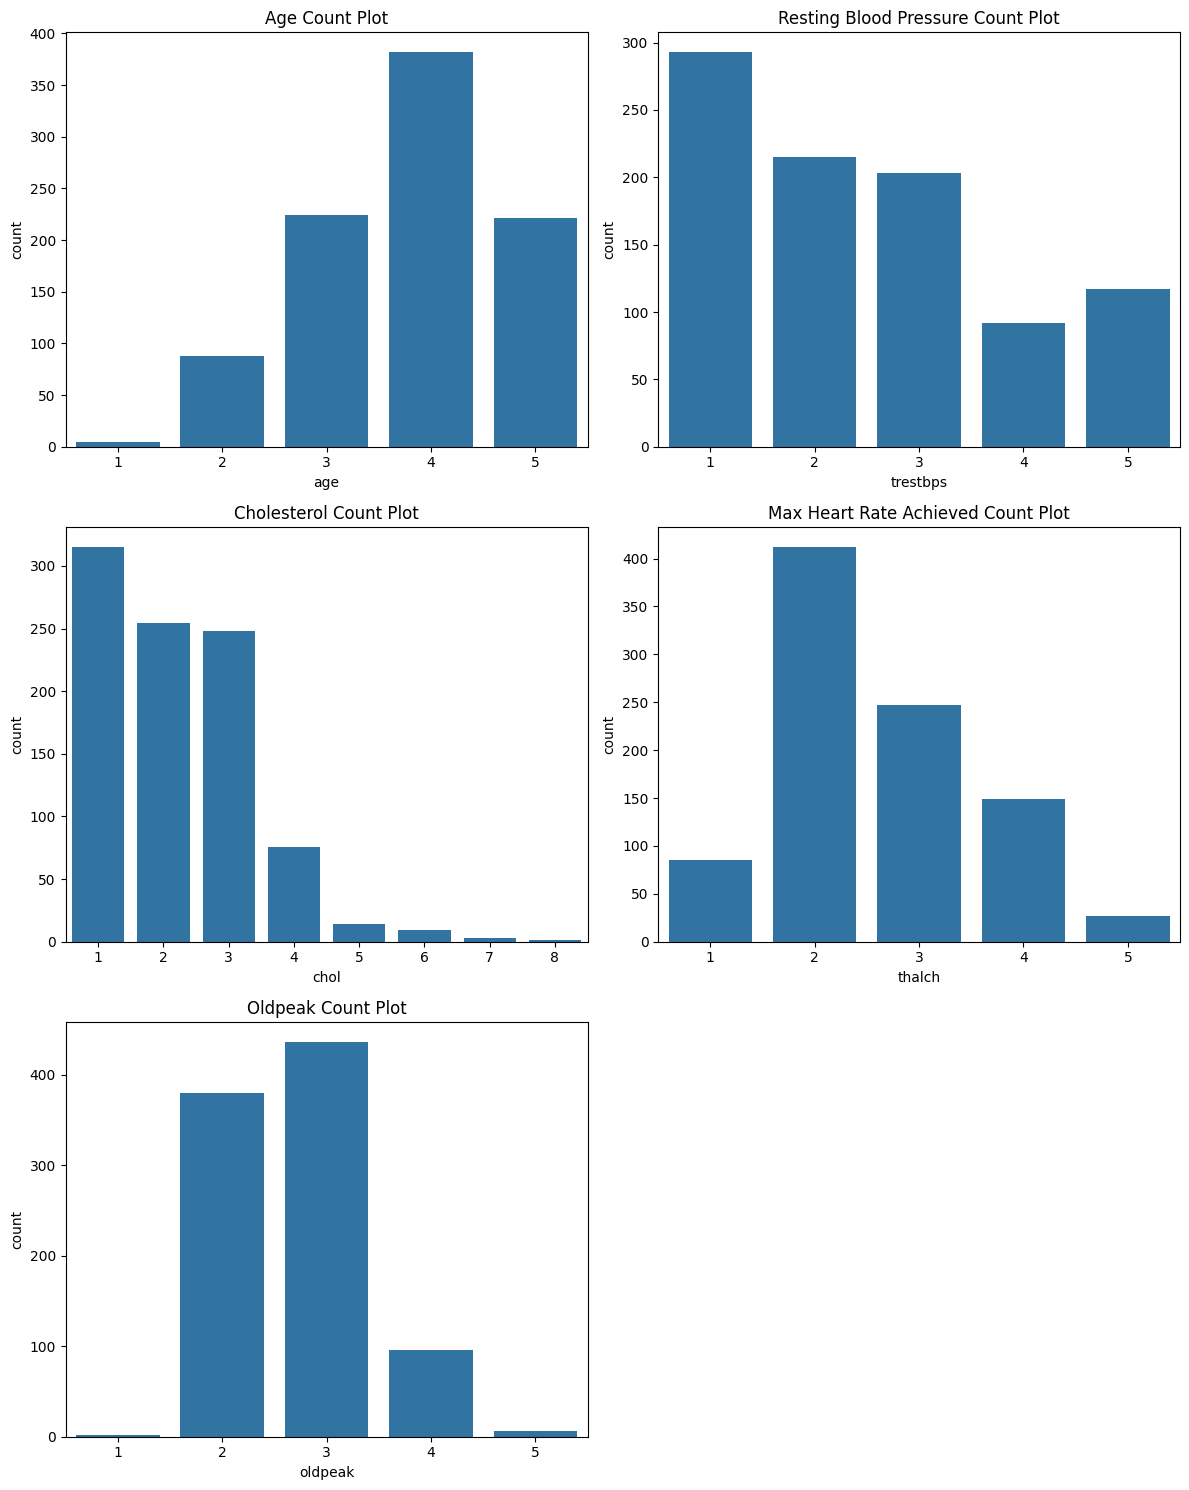

In [24]:
# Re-plot the binned features

fig, axs = plt.subplots(3, 2, figsize=(12, 15))

sns.countplot(x='age', data=df, ax=axs[0, 0])
axs[0, 0].set_title('Age Count Plot')

sns.countplot(x='trestbps', data=df, ax=axs[0, 1])
axs[0, 1].set_title('Resting Blood Pressure Count Plot')

sns.countplot(x='chol', data=df, ax=axs[1, 0])
axs[1, 0].set_title('Cholesterol Count Plot')

sns.countplot(x='thalch', data=df, ax=axs[1, 1])
axs[1, 1].set_title('Max Heart Rate Achieved Count Plot')

sns.countplot(x='oldpeak', data=df, ax=axs[2, 0])
axs[2, 0].set_title('Oldpeak Count Plot')

fig.delaxes(axs[2, 1])

plt.tight_layout()
plt.show()

In [25]:
# check df
df.head()

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,5,1,1,1,4,2,1,2,3,0,4,1,0,2,0
1,5,1,1,4,5,3,0,2,2,1,3,2,3,1,2
2,5,1,1,4,1,2,0,2,2,1,4,2,2,1,1
3,2,1,1,3,2,3,0,0,5,0,4,1,0,1,0
4,3,0,1,2,2,2,0,2,4,0,3,3,0,1,0


In [26]:
# check nans
df.isnull().sum()

age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

In [27]:
# feature correlation matrix in dataframe

correlation_matrix = df.corr()
num_corr = correlation_matrix['num'].sort_values(ascending=False)
print(num_corr)

num         1.000000
ca          0.742812
exang       0.420086
oldpeak     0.411309
cp          0.397896
thal        0.337131
age         0.322458
dataset     0.276203
sex         0.259342
trestbps    0.170702
fbs         0.129539
restecg     0.123069
chol       -0.101362
thalch     -0.346611
slope      -0.473169
Name: num, dtype: float64


In [28]:
# Define features and target variable

X = df.drop('num', axis=1)
y = df['num']

In [29]:
# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [30]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Define ML models
ml_models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB()
}

# Train and evaluate each model
for name, model in ml_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Model: {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    

   
 

c:\New folder\envs\tf_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Logistic Regression
Accuracy: 0.7934782608695652
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        82
           1       0.75      0.77      0.76        53
           2       0.85      0.50      0.63        22
           3       0.59      0.76      0.67        21
           4       0.71      0.83      0.77         6

    accuracy                           0.79       184
   macro avg       0.76      0.75      0.74       184
weighted avg       0.80      0.79      0.79       184

Model: Random Forest
Accuracy: 0.8206521739130435
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        82
           1       0.84      0.77      0.80        53
           2       0.68      0.68      0.68        22
           3       0.68      0.90      0.78        21
           4       0.60      0.50      0.55         6

    accuracy                           0.82       184
   macro avg       0.74  

In [31]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Define ML models
ml_models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB()
}

# Initialize a list to store evaluation metrics
results = []

# Train and evaluate each model
for name, model in ml_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append results
    results.append([name, accuracy, recall, precision, f1])

    # Print classification report
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))

# Create DataFrame to display results
df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Recall", "Precision", "F1-Score"])
print("\nFinal Model Performance Metrics:")
print(df_results)


c:\New folder\envs\tf_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        82
           1       0.75      0.77      0.76        53
           2       0.85      0.50      0.63        22
           3       0.59      0.76      0.67        21
           4       0.71      0.83      0.77         6

    accuracy                           0.79       184
   macro avg       0.76      0.75      0.74       184
weighted avg       0.80      0.79      0.79       184

Model: Random Forest
              precision    recall  f1-score   support

           0       0.95      0.89      0.92        82
           1       0.81      0.81      0.81        53
           2       0.70      0.73      0.71        22
           3       0.76      0.90      0.83        21
           4       0.83      0.83      0.83         6

    accuracy                           0.85       184
   macro avg       0.81      0.83      0.82       184
weighted avg       0.85      